# bias studies with full systematics

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize, basinhopping
from scipy.stats import norm
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 34637,
  "iopub_port": 42685,
  "stdin_port": 38799,
  "control_port": 55721,
  "hb_port": 49051,
  "ip": "127.0.0.1",
  "key": "9ec83b2f-03e6cf090f8d5ea9bbe91867",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-07a9a759-cd42-4667-bbc7-5bcac74c2757.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/updated_e_sf/'
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',  
              'emu', 
              'mutau', 'etau', 
              'mu4j', 'e4j'
             ]
plot_labels = fh.fancy_labels

# initialize fit data
fit_data = fh.FitData(input_dir, selections, processes, process_cut=0.01)
params = fit_data._parameters
params_pre = fit_data.get_params_init().values.copy()

In [3]:
# generate scan points
beta_scan_vals = ScanParameters(['beta_e', 'beta_mu', 'beta_tau'], 
                                [(0.104, 0.118), (0.104, 0.118), (0.104, 0.118)], 
                                [5, 5, 5]
                                )
scan_vals = np.array(beta_scan_vals.get_scan_vals()[0])
beta_h = np.transpose([1 - np.sum(scan_vals, axis=1)])
scan_vals = np.hstack((scan_vals, beta_h, np.outer(np.ones(scan_vals.shape[0]), params_pre[4:])))

In [4]:
# carry out the scan #

# minimizer options
min_options = dict(
                   #eps=1e-10,
                   #gtol=1e-2, 
                   disp=True
                  )

results = []
cost = []
sv_accept = []
mask = fit_data._pmask
#mask[71:] = False
pinit = params_pre[mask]
for sv in tqdm_notebook(scan_vals):
    
    # randomize n.p.
    mask[:4] = False
    np_random = params_pre[mask] + fit_data._perr_init[mask]*np.random.randn(mask.sum())
    fit_data._pval_init[mask] = np_random
    #sv[mask] = np_random
    mask[:4] = True
    
    # generate data from scan values w/ statistical variation
    sample = dict()
    for category in fit_data._categories:
        val, var = fit_data.mixture_model(sv, category)
        sample[category] = [np.random.poisson(val), val]
        #sample[category] = [val, val]

    # carry out minimization
    result = minimize(fit_data.objective, pinit,
                      method  = 'BFGS', 
                      options = min_options,
                      jac     = fit_data.objective_jacobian,
                      args    = (sample)
                     )
    print(' ', result.success, fit_data.objective(pinit), fit_data.objective(sv[mask]), result.fun)
    #print(' jacobian: ', result.jac)
    #print(' init vals: ', pinit)
    #print(' nps: ', np_random)
    print(' scan vals: ', sv[:4])
    print(' fit vals:', result.x[:4], end='\n\n')

    results.append(result.x)
    cost.append(result.fun)
    sv_accept.append(sv[mask])
    

         Current function value: 129.908224
         Iterations: 70
         Function evaluations: 159
         Gradient evaluations: 148
  False 2412.9789280190157 2828.8588475010433 129.908223650997
 scan vals:  [0.104 0.104 0.104 0.688]
 fit vals: [0.1043 0.104  0.1044 0.6873]

         Current function value: 124.980120
         Iterations: 76
         Function evaluations: 156
         Gradient evaluations: 144
  False 2389.301700209081 2705.7641553765025 124.98011953599303
 scan vals:  [0.104  0.104  0.1075 0.6845]
 fit vals: [0.1037 0.104  0.1092 0.6831]

         Current function value: 121.846013
         Iterations: 67
         Function evaluations: 136
         Gradient evaluations: 124
  False 2400.2592370902585 2644.3824804001583 121.84601298072445
 scan vals:  [0.104 0.104 0.111 0.681]
 fit vals: [0.1043 0.1046 0.1119 0.6792]

         Current function value: 114.164578
         Iterations: 69
         Function evaluations: 119
         Gradient evaluations: 108
  False 2

         Current function value: 112.146187
         Iterations: 64
         Function evaluations: 133
         Gradient evaluations: 122
  False 2395.739007853209 7485.850716023117 112.1461867882298
 scan vals:  [0.104  0.118  0.1145 0.6635]
 fit vals: [0.1043 0.118  0.1149 0.6628]

         Current function value: 115.549064
         Iterations: 68
         Function evaluations: 163
         Gradient evaluations: 151
  False 2417.542456812283 7624.524869928216 115.54906352999305
 scan vals:  [0.104 0.118 0.118 0.66 ]
 fit vals: [0.1036 0.1185 0.1188 0.6592]

         Current function value: 135.205675
         Iterations: 59
         Function evaluations: 125
         Gradient evaluations: 114
  False 2404.9271495557473 2456.5698992412354 135.20567458863974
 scan vals:  [0.1075 0.104  0.104  0.6845]
 fit vals: [0.1074 0.1037 0.1051 0.6838]

         Current function value: 118.980068
         Iterations: 55
         Function evaluations: 108
         Gradient evaluations: 98
  False 

         Current function value: 134.556877
         Iterations: 65
         Function evaluations: 172
         Gradient evaluations: 161
  False 2400.6513108526738 7297.60852059115 134.556877084214
 scan vals:  [0.1075 0.118  0.1075 0.667 ]
 fit vals: [0.1076 0.1182 0.1085 0.6658]

         Current function value: 127.437262
         Iterations: 68
         Function evaluations: 141
         Gradient evaluations: 130
  False 2398.8282872627074 7391.640326449983 127.43726167262713
 scan vals:  [0.1075 0.118  0.111  0.6635]
 fit vals: [0.1072 0.1182 0.1138 0.6608]

         Current function value: 117.855800
         Iterations: 71
         Function evaluations: 177
         Gradient evaluations: 165
  False 2390.845106454448 7506.40056692127 117.85580036471998
 scan vals:  [0.1075 0.118  0.1145 0.66  ]
 fit vals: [0.108  0.1186 0.1126 0.6608]

         Current function value: 112.277535
         Iterations: 66
         Function evaluations: 168
         Gradient evaluations: 157
  Fals

         Current function value: 115.824900
         Iterations: 72
         Function evaluations: 127
         Gradient evaluations: 116
  False 2407.5854010145104 7827.509437392769 115.824900006772
 scan vals:  [0.111 0.118 0.104 0.667]
 fit vals: [0.1109 0.118  0.1033 0.6678]

         Current function value: 121.227160
         Iterations: 67
         Function evaluations: 116
         Gradient evaluations: 105
  False 2396.466969056269 7915.016496672881 121.22716026084292
 scan vals:  [0.111  0.118  0.1075 0.6635]
 fit vals: [0.1098 0.1172 0.1092 0.6639]

         Current function value: 115.590466
         Iterations: 71
         Function evaluations: 183
         Gradient evaluations: 171
  False 2398.804391936516 8043.401404748984 115.59046592666054
 scan vals:  [0.111 0.118 0.111 0.66 ]
 fit vals: [0.1114 0.1182 0.1098 0.6605]

         Current function value: 112.880837
         Iterations: 74
         Function evaluations: 122
         Gradient evaluations: 111
  False 2401.

         Current function value: 126.056366
         Iterations: 69
         Function evaluations: 114
         Gradient evaluations: 105
  False 2406.9382524191433 6809.593338013598 126.05636628002415
 scan vals:  [0.1145 0.1145 0.1145 0.6565]
 fit vals: [0.1146 0.1141 0.1169 0.6545]

         Current function value: 131.578975
         Iterations: 71
         Function evaluations: 134
         Gradient evaluations: 123
  False 2401.9280956508946 6981.541187379041 131.57897467768345
 scan vals:  [0.1145 0.1145 0.118  0.653 ]
 fit vals: [0.1142 0.1144 0.1161 0.6553]

         Current function value: 107.676386
         Iterations: 74
         Function evaluations: 124
         Gradient evaluations: 115
  False 2394.3817945652872 9037.12934822027 107.67638578685282
 scan vals:  [0.1145 0.118  0.104  0.6635]
 fit vals: [0.1152 0.119  0.1065 0.6593]

         Current function value: 122.966939
         Iterations: 72
         Function evaluations: 122
         Gradient evaluations: 112
  

         Current function value: 131.677643
         Iterations: 76
         Function evaluations: 161
         Gradient evaluations: 151
  False 2396.396066983875 8295.637875404334 131.67764319102653
 scan vals:  [0.118  0.1145 0.1075 0.66  ]
 fit vals: [0.1185 0.114  0.1086 0.6589]

         Current function value: 137.850272
         Iterations: 75
         Function evaluations: 124
         Gradient evaluations: 114
  False 2401.1543856906474 8449.863128417695 137.85027175471322
 scan vals:  [0.118  0.1145 0.111  0.6565]
 fit vals: [0.1173 0.1141 0.1085 0.6601]

         Current function value: 125.642541
         Iterations: 79
         Function evaluations: 154
         Gradient evaluations: 145
  False 2399.715927437142 8625.097943548113 125.64254087130053
 scan vals:  [0.118  0.1145 0.1145 0.653 ]
 fit vals: [0.1179 0.1146 0.1137 0.6538]

         Current function value: 114.257743
         Iterations: 75
         Function evaluations: 139
         Gradient evaluations: 130
  F

In [5]:
#calculate biases
results = np.array(results)
sv_accept = np.array(sv_accept)
cost = np.array(cost)

diff = (results - sv_accept)
diff[:,:4] /= 0.01*pinit[:4]
#diff[:,:4] /= 0.01*sv_accept[:,:4]
diff[:,4:diff.shape[1]] /= params['err_init'][4:diff.shape[1]].values

#diff = np.array([d for d in diff if np.all((d > -10) & (d < 10))])

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


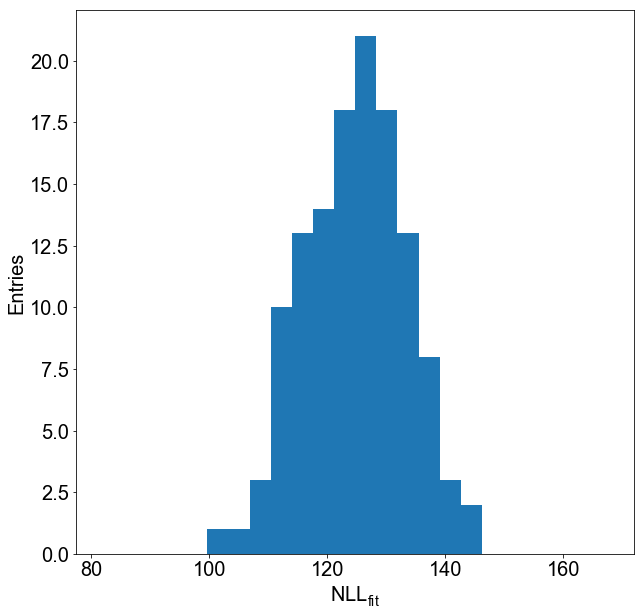

In [6]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

cost = cost[cost<600]
cost_mean, cost_err = cost.mean(), cost.std()
ax.hist(cost, bins=np.linspace(np.max([0, cost_mean - 5*cost_err]), cost_mean + 5*cost_err, 25), histtype='stepfilled')
ax.set_xlabel(r'$NLL_{fit}$')
ax.set_ylabel('Entries')

plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


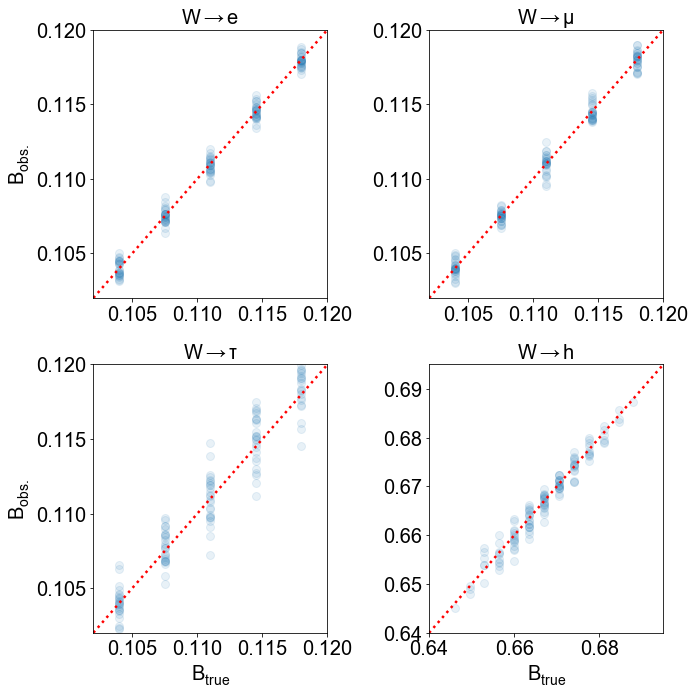

In [7]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=False, sharey=False)

beta_val = sv_accept[:,:4]
beta_obs = results[:,:4]

ax = axes[0][0]
ax.plot(beta_val[:,0], beta_obs[:,0], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
ax.plot(beta_val[:,1], beta_obs[:,1], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
ax.plot(beta_val[:,2], beta_obs[:,2], 'C0o', alpha=0.1)
ax.plot([0.1, 0.12], [0.1, 0.12], 'r:')
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)
ax.set_ylabel(r'$B_{obs.}$')
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
ax.plot(beta_val[:,3], beta_obs[:,3], 'C0o', alpha=0.1)
ax.plot([0.64, 0.72], [0.64, 0.72], 'r:')
ax.set_xlim(0.64, 0.695)
ax.set_ylim(0.64, 0.695)
ax.set_xlabel(r'$B_{true}$')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_scan.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


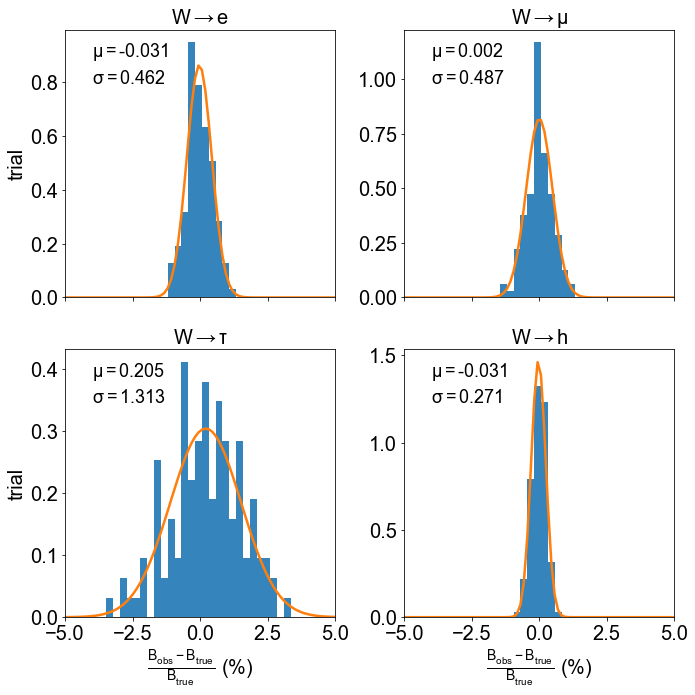

In [8]:
# branching fraction scans
fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor='white', sharex=True, sharey=False)
bins = np.linspace(-5, 5, 80)

ax = axes[0][0]
dbeta = 100*(beta_obs[:,0] - beta_val[:,0])/beta_val[:,0]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlim(-5., 5.)
ax.set_ylim(0., None)
ax.set_ylabel('trial')
ax.set_title(r'$W\rightarrow e$', size=20)

ax = axes[0][1]
dbeta = 100*(beta_obs[:,1] - beta_val[:,1])/beta_val[:,1]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_title(r'$W\rightarrow\mu$', size=20)

ax = axes[1][0]
dbeta = 100*(beta_obs[:,2] - beta_val[:,2])/beta_val[:,2]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_ylabel('trial')
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow\tau$', size=20)

ax = axes[1][1]
dbeta = 100*(beta_obs[:,3] - beta_val[:,3])/beta_val[:,3]
ax.hist(dbeta, bins[::2], alpha=0.9, density=True)
ax.plot(bins, norm.pdf(bins, loc=dbeta.mean(), scale=dbeta.std()))
ax.text(0.1, 0.9, r'$\mu =$' + f'{dbeta.mean():.3f}', transform=ax.transAxes)
ax.text(0.1, 0.8, r'$\sigma =$' + f'{dbeta.std():.3f}', transform=ax.transAxes)
ax.set_xlabel(r'$\frac{B_{obs} - B_{true}}{B_{true}}$ (%)')
ax.set_title(r'$W\rightarrow h$', size=20)

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta_bias.pdf')
plt.show()

In [9]:
#plotting the results
fig, axes = plt.subplots(2, 1, figsize=(30, 15), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})

df_pulls = pd.read_csv('local_data/pulls.csv').query('active == True')
df_pulls.loc[:3, 'ratio'] *= 100
df_pulls = df_pulls.set_index('name')
#df_pulls = df_pulls.drop('top_pt')
pull_post = (df_pulls['val_fit'] - df_pulls['val_init'])/df_pulls['err_init']

nparams = params[mask].shape[0]
xticks = np.outer(np.arange(nparams), np.ones(diff.shape[0])).T
ax = axes[0]
ax.plot(xticks+1,  diff, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff.mean(axis=0), diff.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.errorbar(xticks[0]+1,  pull_post.values, df_pulls['ratio'], fmt='C1o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)
#ax.boxplot(diff)

# extra dressing
ax.set_ylabel(r'$\delta\theta_{post}/\delta\theta_{pre}$')
ax.set_xlim(3.5, nparams+0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

ax = axes[1]
err_ratio = diff.std(axis=0)/df_pulls['ratio'].values
ax.plot(xticks[0]+1,  err_ratio, 'ko', alpha=0.9, markersize=10)
#ax.errorbar(xticks[0]+1,  diff.mean(axis=0), , fmt='C0o', capsize=10, elinewidth=5)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params[mask].label, size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'toys/$\mathcal{H}_{NLL}$')
ax.set_ylim(0.25, 1.75)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/new_pulls.pdf')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

xticks = np.outer(np.arange(4), np.ones(diff.shape[0])).T
ax.plot(xticks+1,  diff[:,:4], 'ko', alpha=0.1, markersize=4)
#ax.boxplot(diff)
ax.errorbar(xticks[0,:4]+1,  diff[:,:4].mean(axis=0), diff[:,:4].std(axis=0), fmt='C0o', capsize=10, elinewidth=5)
ax.fill_between([-0.5, nparams+0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

print(diff[:,:4].std(axis=0))

# extra dressing
ax.set_xticks(xticks[0,:4]+1)
ax.set_xticklabels(params.label[:4], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\delta\theta/\theta$ (%)')
ax.set_xlim(0.5, nparams+0.5)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/beta.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor='white')

ip_low, ip_high = 4, 7 + fit_data._nnorm
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/norm_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 18, 46
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_reco_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 47, 65
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_btag_params.pdf')
plt.show()

In [ ]:
#plotting the results
fig, ax = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')

ip_low, ip_high = 65, 84
xticks = np.outer(np.arange(ip_high-ip_low), np.ones(diff.shape[0])).T
diff_trim = diff[:, ip_low:ip_high]
ax.plot(xticks+1,  diff_trim, 'ko', alpha=0.1, markersize=4, )
ax.errorbar(xticks[0]+1,  diff_trim.mean(axis=0), diff_trim.std(axis=0), fmt='C0o', capsize=10, elinewidth=5)

# extra dressing
ax.fill_between([0.5, ip_high - ip_low + 0.5], [-1, -1], [1, 1], color='C0', alpha=0.25)

ax.set_xticks(xticks[0]+1)
ax.set_xticklabels(params.label[ip_low:ip_high], size=24)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_ylabel(r'$\sigma_{toys}/\sigma_{pre}$')
ax.set_xlim(0.5, ip_high - ip_low + 0.5)
ax.set_ylim(-2.5, 2.5)
ax.grid(linestyle='--', axis='y')

plt.tight_layout()
plt.savefig('plots/systematics/bias_tests/shape_jes_params.pdf')
plt.show()